In [797]:
import numpy as np
import pandas as pd
import plotly.express as px
from darts.metrics.metrics import r2_score, smape, mae, mape
from darts.dataprocessing.transformers.scaler import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.models import RNNModel, LightGBMModel
from darts.timeseries import TimeSeries

In [798]:
raw_data = pd.read_csv('site_id_1.csv', parse_dates=['timestamp'])

In [799]:
raw_data.head()

timestamp  meter_reading  air_temperature  cloud_coverage  \
0 2016-01-01 00:00:00      4154.2543              3.8             NaN   
1 2016-01-01 01:00:00      8337.2696              3.7             0.0   
2 2016-01-01 02:00:00      8317.9158              2.6             0.0   
3 2016-01-01 03:00:00      8392.4680              2.0             0.0   
4 2016-01-01 04:00:00      8109.9117              2.3             0.0   

   dew_temperature  sea_level_pressure  wind_direction  wind_speed  
0              2.4              1020.9           240.0         3.1  
1              2.4              1021.6           230.0         2.6  
2              1.9              1021.9             0.0         0.0  
3              1.2              1022.3           170.0         1.5  
4              1.8              1022.7           110.0         1.5

In [800]:
#Check for missing timesteps
def is_missing_timesteps(df, date_col = 'date', freq='1H'):
    index_series  = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    return not index_series.equals(pd.Index(pd.to_datetime(df[date_col])))

In [801]:
is_missing_timesteps(raw_data, date_col='timestamp')

False

In [802]:
#So, the dataframe is missing some datetime steps, Let's extract missing timesteps
def get_missing_timesteps(df, date_col ='date', freq='H'):
    index_series = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    df_index = pd.Index(pd.to_datetime(df[date_col]))
    return index_series.difference(df_index)

In [803]:
get_missing_timesteps(raw_data, date_col='timestamp')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [804]:
raw_data.head()

timestamp  meter_reading  air_temperature  cloud_coverage  \
0 2016-01-01 00:00:00      4154.2543              3.8             NaN   
1 2016-01-01 01:00:00      8337.2696              3.7             0.0   
2 2016-01-01 02:00:00      8317.9158              2.6             0.0   
3 2016-01-01 03:00:00      8392.4680              2.0             0.0   
4 2016-01-01 04:00:00      8109.9117              2.3             0.0   

   dew_temperature  sea_level_pressure  wind_direction  wind_speed  
0              2.4              1020.9           240.0         3.1  
1              2.4              1021.6           230.0         2.6  
2              1.9              1021.9             0.0         0.0  
3              1.2              1022.3           170.0         1.5  
4              1.8              1022.7           110.0         1.5

In [805]:
raw_data.isnull().mean()

timestamp             0.000000
meter_reading         0.000000
air_temperature       0.002505
cloud_coverage        0.806352
dew_temperature       0.002505
sea_level_pressure    0.008311
wind_direction        0.002732
wind_speed            0.002391
dtype: float64

In [806]:
raw_data['air_temperature'] = raw_data['air_temperature'].interpolate()
raw_data['cloud_coverage'] = raw_data['cloud_coverage'].fillna(-1)
raw_data['dew_temperature'] = raw_data['dew_temperature'].interpolate()
raw_data['sea_level_pressure'] = raw_data['sea_level_pressure'].interpolate()
raw_data['wind_direction'] = raw_data['wind_direction'].interpolate()
raw_data['wind_speed'] = raw_data['wind_speed'].interpolate()

In [807]:
#Adding windows statsitics
raw_data['rolling mean'] = raw_data['meter_reading'].rolling(window=10, min_periods=0).mean()
raw_data['rolling std'] = raw_data['meter_reading'].rolling(window=10, min_periods=0).std()
raw_data['weighted mean'] = raw_data['meter_reading'].ewm(com=5).mean()

In [808]:
#import tsfel
#cfg_file = tsfel.get_features_by_domain()
#X_feat = tsfel.time_series_features_extractor(cfg_file, raw_data['meter_reading'].to_frame(), window_size=7, fs=1)

In [809]:
type(raw_data['meter_reading'].to_frame())

pandas.core.frame.DataFrame

In [810]:
raw_data.isnull().mean()

timestamp             0.000000
meter_reading         0.000000
air_temperature       0.000000
cloud_coverage        0.000000
dew_temperature       0.000000
sea_level_pressure    0.000000
wind_direction        0.000000
wind_speed            0.000000
rolling mean          0.000000
rolling std           0.000114
weighted mean         0.000000
dtype: float64

In [811]:
raw_data['meter_reading'] = raw_data['meter_reading'].clip(upper=np.mean(raw_data.meter_reading) + 3*np.std(raw_data.meter_reading), lower=np.mean(raw_data.meter_reading) - 3*np.std(raw_data.meter_reading))

In [812]:
time_col = 'timestamp'
value_cols = list(raw_data.columns.drop('timestamp'))

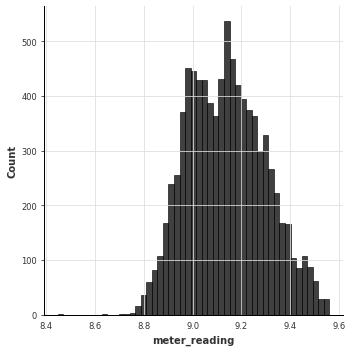

In [813]:
import seaborn as sns
sns.displot(np.log1p(raw_data['meter_reading']))

In [814]:
ts_data = TimeSeries.from_dataframe(raw_data, time_col='timestamp', value_cols=value_cols)

In [815]:
ts_data = ts_data.add_holidays('US')
ts_data = ts_data.add_datetime_attribute('hour', cyclic=True)
ts_data = ts_data.add_datetime_attribute('month', one_hot=True)
ts_data = ts_data.add_datetime_attribute('dayofweek', cyclic=True)
ts_data = ts_data.add_datetime_attribute('dayofyear', cyclic=True)

In [816]:
px.line(raw_data, x='timestamp', y=['meter_reading'])

In [817]:
px.line(raw_data, x='timestamp', y=['meter_reading'])

In [818]:
load_std = np.std(ts_data['meter_reading'])
load_std

component
meter_reading    1519.955035
dtype: float64

In [819]:
load_mean = np.mean(ts_data['meter_reading'])
load_mean

component
meter_reading    9411.852127
dtype: float64

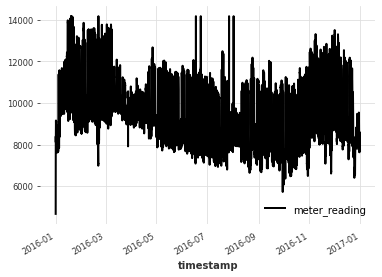

In [820]:
ts_data['meter_reading'].plot()

In [821]:
raw_data['weighted mean'] = raw_data['meter_reading'].ewm(com=5).mean()
px.line(raw_data, x='timestamp', y=['meter_reading', 'weighted mean'])

In [822]:
raw_data.head()

timestamp  meter_reading  air_temperature  cloud_coverage  \
0 2016-01-01 00:00:00    4659.503945              3.8            -1.0   
1 2016-01-01 01:00:00    8337.269600              3.7             0.0   
2 2016-01-01 02:00:00    8317.915800              2.6             0.0   
3 2016-01-01 03:00:00    8392.468000              2.0             0.0   
4 2016-01-01 04:00:00    8109.911700              2.3             0.0   

   dew_temperature  sea_level_pressure  wind_direction  wind_speed  \
0              2.4              1020.9           240.0         3.1   
1              2.4              1021.6           230.0         2.6   
2              1.9              1021.9             0.0         0.0   
3              1.2              1022.3           170.0         1.5   
4              1.8              1022.7           110.0         1.5   

   rolling mean  rolling std  weighted mean  
0   4154.254300          NaN    4659.503945  
1   6245.761950  2957.838484    6665.557939  
2   6936.479900  2409.497481    7319.237972  
3   7300.476925  2097.719574    7664.718875  
4   7462.363880  1852.392369    7788.771746

In [823]:
target_col = ['meter_reading']
cov_cols = list(ts_data.columns.drop(target_col))

In [824]:
train, test = ts_data.split_after(0.85)

train_target = train[target_col]
train_cov = train[cov_cols]

test_target = test[target_col]
test_cov = test[cov_cols]

In [825]:
from torch import Tensor, sqrt
from torch.nn import MSELoss
import torch
def dont_undershoot_loss(preds: Tensor, targets: Tensor) -> Tensor:
    """ penalize undershooting much more than overshooting (regression loss) """
    raw_diff = preds - targets
    is_undershoot = raw_diff < 0
    peak_loss = torch.zeros_like(raw_diff)
    peak_loss[is_undershoot] = (torch.abs(raw_diff[is_undershoot]) * 2)**2
    peak_loss[~is_undershoot] = torch.abs(raw_diff[~is_undershoot])** 2
    peak_loss = peak_loss.sum()
    rmse_loss = torch.zeros_like(raw_diff)
    rmse_loss = sqrt((rmse_loss**2).sum())
    return 0.10*peak_loss + 0.90*rmse_loss

In [826]:
from treeboost_autograd import LightGbmObjective
custom_obj = LightGbmObjective(loss_function=dont_undershoot_loss)

In [850]:
lgb_params = {
    'feval': custom_obj,
    'objective': custom_obj
}
lgb_model = LightGBMModel(
    lags=24*7,
    lags_past_covariates=24*14,
    lags_future_covariates=(24, 1),
    n_iter = 500,
    metric='rmse',
    early_stopping_rounds=30)

In [851]:
train_cov.columns

Index(['air_temperature', 'cloud_coverage', 'dew_temperature',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'rolling mean',
       'rolling std', 'weighted mean', 'holidays', 'hour_sin', 'hour_cos',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos'],
      dtype='object', name='component')

In [852]:
lgb_model.fit(train_target, past_covariates=train_cov, verbose=True, val_series=test_target, val_past_covariates=test_cov, future_covariates=train_cov.append(test_cov), val_future_covariates=train_cov.append(test_cov))

/Users/sharabhshuklaair/opt/anaconda3/envs/armts/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning:

Found `n_iter` in params. Will use it instead of argument

/Users/sharabhshuklaair/opt/anaconda3/envs/armts/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, n_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30


/Users/sharabhshuklaair/opt/anaconda3/envs/armts/lib/python3.9/site-packages/lightgbm/basic.py:154: UserWarning:

Converting column-vector to 1d array



[1]	valid_0's rmse: 1456.41
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 1323.13
[3]	valid_0's rmse: 1195.13
[4]	valid_0's rmse: 1084.8
[5]	valid_0's rmse: 988.018
[6]	valid_0's rmse: 904.179
[7]	valid_0's rmse: 816.44
[8]	valid_0's rmse: 751.956
[9]	valid_0's rmse: 688.891
[10]	valid_0's rmse: 631.948
[11]	valid_0's rmse: 581.855
[12]	valid_0's rmse: 539.743
[13]	valid_0's rmse: 500.618
[14]	valid_0's rmse: 469.016
[15]	valid_0's rmse: 438.303
[16]	valid_0's rmse: 413.262
[17]	valid_0's rmse: 394.971
[18]	valid_0's rmse: 374.937
[19]	valid_0's rmse: 360.331
[20]	valid_0's rmse: 344.855
[21]	valid_0's rmse: 335.767
[22]	valid_0's rmse: 328.427
[23]	valid_0's rmse: 321.907
[24]	valid_0's rmse: 315.08
[25]	valid_0's rmse: 307.138
[26]	valid_0's rmse: 301.403
[27]	valid_0's rmse: 297.709
[28]	valid_0's rmse: 292.452
[29]	valid_0's rmse: 286.956
[30]	valid_0's rmse: 284.566
[31]	valid_0's rmse: 281.545
[32]	valid_0's rmse: 278.153
[33]	valid_0's rmse: 27

In [714]:
import pickle
pickle.dump(lgb_model, open('lgb_model_withcustom_loss.pkl', 'wb'))

In [853]:
pred = lgb_model.predict(series=train_target, n=len(test_target) - 24, past_covariates=train_cov.append(test_cov))

In [854]:
from darts.metrics.metrics import r2_score, smape, rmsle, rmse

In [855]:
smape(test_target, pred)

5.2189477541319915

In [856]:
rmse(test_target, pred)

643.0040877419136

In [857]:
rmsle(test_target, pred)

0.07076080228852177

In [858]:
test_target.plot(label='target')
pred.plot(label='predictions')

In [860]:
pred_df = pd.DataFrame({'target': test_target[:-24].all_values().reshape(len(test_target)-24), 'prediction': pred.all_values().reshape(len(test_target) - 24)}, index=test_target.time_index[:-24])

In [861]:
px.line(pred_df, x=pred_df.index, y=['target', 'prediction'])

In [473]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, shared_xaxes=True)

In [214]:
fig.add_trace(go.Scatter(x=pred.time_index, y=pred.all_values().reshape(len(test_target))), row=1, col=1)
fig.add_trace(go.Scatter(x=test_target.time_index, y=test_target.all_values().reshape(len(test_target))), row=1, col=1)